# Pedestrian Attribute Recognition

**Task:** Pedestrian Attribute Recognition is a computer vision task that involves identifying and classifying various attributes of pedestrians within images.

**Dataset:** PETA dataset. I have considered 35 attributes for this task.

**Problem Faced to Use this Dataset:** The labels of the images were written as text in a separate text file. I have encoded all 35 attributes for feeding them to a deep learning model.

**Model:** InceptionNet [As we know it was the winner of the ImageNet Large Scale Visual Recognition Competition in 2014, by ingeniously incorporating Inception Modules, this architecture optimizes accuracy and speed by skillfully curtailing computational complexity. Stacking 1X1 convolutions fosters network depth, gracefully addressing challenges like overfitting. Unlike traditional linear kernel stacking, this method orchestrates parallel kernel sizes, harmonizing their impact within the CNN's strata]

## Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import argparse
import os
import shutil
import time
import sys
import numpy as np
from PIL import Image
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.nn.functional as F

model_path = "/content/drive/My Drive/hacktech/"
sys.path.append(model_path)

import model as models
device = torch.device("cuda:0")
tensor = torch.randn(3, 3).to(device)

np.random.seed(1)
torch.manual_seed(1)
if torch.cuda.is_available(): torch.cuda.manual_seed(1)
else: print('[CUDA unavailable]'); sys.exit()

Mounted at /content/drive


In [2]:
best_accu = 0
EPS = 1e-12

## Loading Data & Perform Basic Preprocessing (PETA Dataset)

In [3]:
def default_loader(path):
    return Image.open(path).convert('RGB')
class MultiLabelDataset(data.Dataset):
    def __init__(self, root, label, transform = None, loader = default_loader):
        images = []
        labels = open(label).readlines()
        for line in labels:
            items = line.split()
            img_name = items.pop(0)
            if os.path.isfile(os.path.join(root, img_name)):
                cur_label = tuple([int(v) for v in items])
                images.append((img_name, cur_label))
            else:
                print(os.path.join(root, img_name) + 'Not Found.')
        self.root = root
        self.images = images
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        img_name, label = self.images[index]
        img = self.loader(os.path.join(self.root, img_name))
        raw_img = img.copy()
        if self.transform is not None:
            img = self.transform(img)
        return img, torch.Tensor(label)

    def __len__(self):
        return len(self.images)


attr_nums = {}
attr_nums['peta'] = 35

description = {}
description['peta'] = ['Age16-30',
                        'Age31-45',
                        'Age46-60',
                        'AgeAbove61',
                        'Backpack',
                        'CarryingOther',
                        'Casual lower',
                        'Casual upper',
                        'Formal lower',
                        'Formal upper',
                        'Hat',
                        'Jacket',
                        'Jeans',
                        'Leather Shoes',
                        'Logo',
                        'Long hair',
                        'Male',
                        'Messenger Bag',
                        'Muffler',
                        'No accessory',
                        'No carrying',
                        'Plaid',
                        'PlasticBags',
                        'Sandals',
                        'Shoes',
                        'Shorts',
                        'Short Sleeve',
                        'Skirt',
                        'Sneaker',
                        'Stripes',
                        'Sunglasses',
                        'Trousers',
                        'Tshirt',
                        'UpperOther',
                        'V-Neck']

def Get_Dataset(experiment, approach):

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform_train = transforms.Compose([
        transforms.Resize(size=(256, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
        ])
    transform_val = transforms.Compose([
        transforms.Resize(size=(256, 128)),
        transforms.ToTensor(),
        normalize
        ])
    transform_test = transforms.Compose([
        transforms.Resize(size=(256, 128)),
        transforms.ToTensor(),
        normalize
        ])

    if experiment == 'peta':
        train_dataset = MultiLabelDataset(root='/content/drive/My Drive/hacktech/',
                    label='/content/drive/My Drive/hacktech/PETA_dataset/peta/PETA_train_list.txt', transform=transform_train)
        val_dataset = MultiLabelDataset(root='/content/drive/My Drive/hacktech/',
                    label='/content/drive/My Drive/hacktech/PETA_dataset/peta/PETA_val_list.txt', transform=transform_val)
        test_dataset = MultiLabelDataset(root='/content/drive/My Drive/hacktech/',
                    label='/content/drive/My Drive/hacktech/PETA_dataset/peta/PETA_test_list.txt', transform=transform_test)
        return train_dataset, val_dataset, test_dataset, attr_nums['peta'], description['peta']

## Model Building (Inception Network)

In [4]:
class ChannelAttn(nn.Module):
    def __init__(self, in_channels, reduction_rate=16):
        super(ChannelAttn, self).__init__()
        assert in_channels%reduction_rate == 0
        self.conv1 = nn.Conv2d(in_channels, in_channels // reduction_rate, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels // reduction_rate, in_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # squeeze operation (global average pooling)
        x = F.avg_pool2d(x, x.size()[2:])
        # excitation operation (2 conv layers)
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return torch.sigmoid(x)

class SpatialTransformBlock(nn.Module):
    def __init__(self, num_classes, pooling_size, channels):
        super(SpatialTransformBlock, self).__init__()
        self.num_classes = num_classes
        self.spatial = pooling_size

        self.global_pool = nn.AvgPool2d((pooling_size, pooling_size//2), stride=1, padding=0, ceil_mode=True, count_include_pad=True)

        self.gap_list = nn.ModuleList()
        self.fc_list = nn.ModuleList()
        self.att_list = nn.ModuleList()
        self.stn_list = nn.ModuleList()
        for i in range(self.num_classes):
            self.gap_list.append(nn.AvgPool2d((pooling_size, pooling_size//2), stride=1, padding=0, ceil_mode=True, count_include_pad=True))
            self.fc_list.append(nn.Linear(channels, 1))
            self.att_list.append(ChannelAttn(channels))
            self.stn_list.append(nn.Linear(channels, 4))

    def stn(self, x, theta):
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid, padding_mode='border')
        return x.cuda()

    def transform_theta(self, theta_i, region_idx):
        theta = torch.zeros(theta_i.size(0), 2, 3)
        theta[:,0,0] = torch.sigmoid(theta_i[:,0])
        theta[:,1,1] = torch.sigmoid(theta_i[:,1])
        theta[:,0,2] = torch.tanh(theta_i[:,2])
        theta[:,1,2] = torch.tanh(theta_i[:,3])
        theta = theta.cuda()
        return theta

    def forward(self, features):
        pred_list = []
        bs = features.size(0)
        for i in range(self.num_classes):
            stn_feature = features * self.att_list[i](features) + features

            theta_i = self.stn_list[i](F.avg_pool2d(stn_feature, stn_feature.size()[2:]).view(bs,-1)).view(-1,4)
            theta_i = self.transform_theta(theta_i, i)

            sub_feature = self.stn(stn_feature, theta_i)
            pred = self.gap_list[i](sub_feature).view(bs,-1)
            pred = self.fc_list[i](pred)
            pred_list.append(pred)
        pred = torch.cat(pred_list, 1)
        return pred


In [5]:
class InceptionNet(nn.Module):
    def __init__(self, num_classes=35):
        super(InceptionNet, self).__init__()
        self.num_classes = num_classes
        self.main_branch = BNInception()
        self.global_pool = nn.AvgPool2d((8,4), stride=1, padding=0, ceil_mode=True, count_include_pad=True)
        self.finalfc = nn.Linear(1024, num_classes)

        self.st_3b = SpatialTransformBlock(num_classes, 32, 256*3)
        self.st_4d = SpatialTransformBlock(num_classes, 16, 256*2)
        self.st_5b = SpatialTransformBlock(num_classes, 8, 256)

        # Lateral layers
        self.latlayer_3b = nn.Conv2d(320, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer_4d = nn.Conv2d(608, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer_5b = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)

    def _upsample_add(self, x, y):
        _,_,H,W = y.size()
        up_feat = F.interpolate(x, (H, W), mode='bilinear', align_corners=False)
        return torch.cat([up_feat,y], 1)

    def forward(self, input):
        bs = input.size(0)
        feat_3b, feat_4d, feat_5b = self.main_branch(input)
        main_feat = self.global_pool(feat_5b).view(bs,-1)
        main_pred = self.finalfc(main_feat)

        fusion_5b = self.latlayer_5b(feat_5b)
        fusion_4d = self._upsample_add(fusion_5b, self.latlayer_4d(feat_4d))
        fusion_3b = self._upsample_add(fusion_4d, self.latlayer_3b(feat_3b))

        pred_3b = self.st_3b(fusion_3b)
        pred_4d = self.st_4d(fusion_4d)
        pred_5b = self.st_5b(fusion_5b)

        return pred_3b, pred_4d, pred_5b, main_pred

class BNInception(nn.Module):
    """
        Reference: 'https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/bninception.py'
    """
    def __init__(self):
        super(BNInception, self).__init__()
        inplace = True
        self.conv1_7x7_s2 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        self.conv1_7x7_s2_bn = nn.BatchNorm2d(64, affine=True)
        self.conv1_relu_7x7 = nn.ReLU(inplace)
        self.pool1_3x3_s2 = nn.MaxPool2d((3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
        self.conv2_3x3_reduce = nn.Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        self.conv2_3x3_reduce_bn = nn.BatchNorm2d(64, affine=True)
        self.conv2_relu_3x3_reduce = nn.ReLU(inplace)
        self.conv2_3x3 = nn.Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2_3x3_bn = nn.BatchNorm2d(192, affine=True)
        self.conv2_relu_3x3 = nn.ReLU(inplace)
        self.pool2_3x3_s2 = nn.MaxPool2d((3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
        self.inception_3a_1x1 = nn.Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3a_1x1_bn = nn.BatchNorm2d(64, affine=True)
        self.inception_3a_relu_1x1 = nn.ReLU(inplace)
        self.inception_3a_3x3_reduce = nn.Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3a_3x3_reduce_bn = nn.BatchNorm2d(64, affine=True)
        self.inception_3a_relu_3x3_reduce = nn.ReLU(inplace)
        self.inception_3a_3x3 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3a_3x3_bn = nn.BatchNorm2d(64, affine=True)
        self.inception_3a_relu_3x3 = nn.ReLU(inplace)
        self.inception_3a_double_3x3_reduce = nn.Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3a_double_3x3_reduce_bn = nn.BatchNorm2d(64, affine=True)
        self.inception_3a_relu_double_3x3_reduce = nn.ReLU(inplace)
        self.inception_3a_double_3x3_1 = nn.Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3a_double_3x3_1_bn = nn.BatchNorm2d(96, affine=True)
        self.inception_3a_relu_double_3x3_1 = nn.ReLU(inplace)
        self.inception_3a_double_3x3_2 = nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3a_double_3x3_2_bn = nn.BatchNorm2d(96, affine=True)
        self.inception_3a_relu_double_3x3_2 = nn.ReLU(inplace)
        self.inception_3a_pool = nn.AvgPool2d(3, stride=1, padding=1, ceil_mode=True, count_include_pad=True)
        self.inception_3a_pool_proj = nn.Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3a_pool_proj_bn = nn.BatchNorm2d(32, affine=True)
        self.inception_3a_relu_pool_proj = nn.ReLU(inplace)
        self.inception_3b_1x1 = nn.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3b_1x1_bn = nn.BatchNorm2d(64, affine=True)
        self.inception_3b_relu_1x1 = nn.ReLU(inplace)
        self.inception_3b_3x3_reduce = nn.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3b_3x3_reduce_bn = nn.BatchNorm2d(64, affine=True)
        self.inception_3b_relu_3x3_reduce = nn.ReLU(inplace)
        self.inception_3b_3x3 = nn.Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3b_3x3_bn = nn.BatchNorm2d(96, affine=True)
        self.inception_3b_relu_3x3 = nn.ReLU(inplace)
        self.inception_3b_double_3x3_reduce = nn.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3b_double_3x3_reduce_bn = nn.BatchNorm2d(64, affine=True)
        self.inception_3b_relu_double_3x3_reduce = nn.ReLU(inplace)
        self.inception_3b_double_3x3_1 = nn.Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3b_double_3x3_1_bn = nn.BatchNorm2d(96, affine=True)
        self.inception_3b_relu_double_3x3_1 = nn.ReLU(inplace)
        self.inception_3b_double_3x3_2 = nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3b_double_3x3_2_bn = nn.BatchNorm2d(96, affine=True)
        self.inception_3b_relu_double_3x3_2 = nn.ReLU(inplace)
        self.inception_3b_pool = nn.AvgPool2d(3, stride=1, padding=1, ceil_mode=True, count_include_pad=True)
        self.inception_3b_pool_proj = nn.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3b_pool_proj_bn = nn.BatchNorm2d(64, affine=True)
        self.inception_3b_relu_pool_proj = nn.ReLU(inplace)
        self.inception_3c_3x3_reduce = nn.Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3c_3x3_reduce_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_3c_relu_3x3_reduce = nn.ReLU(inplace)
        self.inception_3c_3x3 = nn.Conv2d(128, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.inception_3c_3x3_bn = nn.BatchNorm2d(160, affine=True)
        self.inception_3c_relu_3x3 = nn.ReLU(inplace)
        self.inception_3c_double_3x3_reduce = nn.Conv2d(320, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_3c_double_3x3_reduce_bn = nn.BatchNorm2d(64, affine=True)
        self.inception_3c_relu_double_3x3_reduce = nn.ReLU(inplace)
        self.inception_3c_double_3x3_1 = nn.Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_3c_double_3x3_1_bn = nn.BatchNorm2d(96, affine=True)
        self.inception_3c_relu_double_3x3_1 = nn.ReLU(inplace)
        self.inception_3c_double_3x3_2 = nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.inception_3c_double_3x3_2_bn = nn.BatchNorm2d(96, affine=True)
        self.inception_3c_relu_double_3x3_2 = nn.ReLU(inplace)
        self.inception_3c_pool = nn.MaxPool2d((3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
        self.inception_4a_1x1 = nn.Conv2d(576, 224, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4a_1x1_bn = nn.BatchNorm2d(224, affine=True)
        self.inception_4a_relu_1x1 = nn.ReLU(inplace)
        self.inception_4a_3x3_reduce = nn.Conv2d(576, 64, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4a_3x3_reduce_bn = nn.BatchNorm2d(64, affine=True)
        self.inception_4a_relu_3x3_reduce = nn.ReLU(inplace)
        self.inception_4a_3x3 = nn.Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4a_3x3_bn = nn.BatchNorm2d(96, affine=True)
        self.inception_4a_relu_3x3 = nn.ReLU(inplace)
        self.inception_4a_double_3x3_reduce = nn.Conv2d(576, 96, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4a_double_3x3_reduce_bn = nn.BatchNorm2d(96, affine=True)
        self.inception_4a_relu_double_3x3_reduce = nn.ReLU(inplace)
        self.inception_4a_double_3x3_1 = nn.Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4a_double_3x3_1_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4a_relu_double_3x3_1 = nn.ReLU(inplace)
        self.inception_4a_double_3x3_2 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4a_double_3x3_2_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4a_relu_double_3x3_2 = nn.ReLU(inplace)
        self.inception_4a_pool = nn.AvgPool2d(3, stride=1, padding=1, ceil_mode=True, count_include_pad=True)
        self.inception_4a_pool_proj = nn.Conv2d(576, 128, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4a_pool_proj_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4a_relu_pool_proj = nn.ReLU(inplace)
        self.inception_4b_1x1 = nn.Conv2d(576, 192, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4b_1x1_bn = nn.BatchNorm2d(192, affine=True)
        self.inception_4b_relu_1x1 = nn.ReLU(inplace)
        self.inception_4b_3x3_reduce = nn.Conv2d(576, 96, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4b_3x3_reduce_bn = nn.BatchNorm2d(96, affine=True)
        self.inception_4b_relu_3x3_reduce = nn.ReLU(inplace)
        self.inception_4b_3x3 = nn.Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4b_3x3_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4b_relu_3x3 = nn.ReLU(inplace)
        self.inception_4b_double_3x3_reduce = nn.Conv2d(576, 96, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4b_double_3x3_reduce_bn = nn.BatchNorm2d(96, affine=True)
        self.inception_4b_relu_double_3x3_reduce = nn.ReLU(inplace)
        self.inception_4b_double_3x3_1 = nn.Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4b_double_3x3_1_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4b_relu_double_3x3_1 = nn.ReLU(inplace)
        self.inception_4b_double_3x3_2 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4b_double_3x3_2_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4b_relu_double_3x3_2 = nn.ReLU(inplace)
        self.inception_4b_pool = nn.AvgPool2d(3, stride=1, padding=1, ceil_mode=True, count_include_pad=True)
        self.inception_4b_pool_proj = nn.Conv2d(576, 128, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4b_pool_proj_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4b_relu_pool_proj = nn.ReLU(inplace)
        self.inception_4c_1x1 = nn.Conv2d(576, 160, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4c_1x1_bn = nn.BatchNorm2d(160, affine=True)
        self.inception_4c_relu_1x1 = nn.ReLU(inplace)
        self.inception_4c_3x3_reduce = nn.Conv2d(576, 128, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4c_3x3_reduce_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4c_relu_3x3_reduce = nn.ReLU(inplace)
        self.inception_4c_3x3 = nn.Conv2d(128, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4c_3x3_bn = nn.BatchNorm2d(160, affine=True)
        self.inception_4c_relu_3x3 = nn.ReLU(inplace)
        self.inception_4c_double_3x3_reduce = nn.Conv2d(576, 128, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4c_double_3x3_reduce_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4c_relu_double_3x3_reduce = nn.ReLU(inplace)
        self.inception_4c_double_3x3_1 = nn.Conv2d(128, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4c_double_3x3_1_bn = nn.BatchNorm2d(160, affine=True)
        self.inception_4c_relu_double_3x3_1 = nn.ReLU(inplace)
        self.inception_4c_double_3x3_2 = nn.Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4c_double_3x3_2_bn = nn.BatchNorm2d(160, affine=True)
        self.inception_4c_relu_double_3x3_2 = nn.ReLU(inplace)
        self.inception_4c_pool = nn.AvgPool2d(3, stride=1, padding=1, ceil_mode=True, count_include_pad=True)
        self.inception_4c_pool_proj = nn.Conv2d(576, 128, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4c_pool_proj_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4c_relu_pool_proj = nn.ReLU(inplace)
        self.inception_4d_1x1 = nn.Conv2d(608, 96, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4d_1x1_bn = nn.BatchNorm2d(96, affine=True)
        self.inception_4d_relu_1x1 = nn.ReLU(inplace)
        self.inception_4d_3x3_reduce = nn.Conv2d(608, 128, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4d_3x3_reduce_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4d_relu_3x3_reduce = nn.ReLU(inplace)
        self.inception_4d_3x3 = nn.Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4d_3x3_bn = nn.BatchNorm2d(192, affine=True)
        self.inception_4d_relu_3x3 = nn.ReLU(inplace)
        self.inception_4d_double_3x3_reduce = nn.Conv2d(608, 160, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4d_double_3x3_reduce_bn = nn.BatchNorm2d(160, affine=True)
        self.inception_4d_relu_double_3x3_reduce = nn.ReLU(inplace)
        self.inception_4d_double_3x3_1 = nn.Conv2d(160, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4d_double_3x3_1_bn = nn.BatchNorm2d(192, affine=True)
        self.inception_4d_relu_double_3x3_1 = nn.ReLU(inplace)
        self.inception_4d_double_3x3_2 = nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4d_double_3x3_2_bn = nn.BatchNorm2d(192, affine=True)
        self.inception_4d_relu_double_3x3_2 = nn.ReLU(inplace)
        self.inception_4d_pool = nn.AvgPool2d(3, stride=1, padding=1, ceil_mode=True, count_include_pad=True)
        self.inception_4d_pool_proj = nn.Conv2d(608, 128, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4d_pool_proj_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4d_relu_pool_proj = nn.ReLU(inplace)
        self.inception_4e_3x3_reduce = nn.Conv2d(608, 128, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4e_3x3_reduce_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_4e_relu_3x3_reduce = nn.ReLU(inplace)
        self.inception_4e_3x3 = nn.Conv2d(128, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.inception_4e_3x3_bn = nn.BatchNorm2d(192, affine=True)
        self.inception_4e_relu_3x3 = nn.ReLU(inplace)
        self.inception_4e_double_3x3_reduce = nn.Conv2d(608, 192, kernel_size=(1, 1), stride=(1, 1))
        self.inception_4e_double_3x3_reduce_bn = nn.BatchNorm2d(192, affine=True)
        self.inception_4e_relu_double_3x3_reduce = nn.ReLU(inplace)
        self.inception_4e_double_3x3_1 = nn.Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_4e_double_3x3_1_bn = nn.BatchNorm2d(256, affine=True)
        self.inception_4e_relu_double_3x3_1 = nn.ReLU(inplace)
        self.inception_4e_double_3x3_2 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.inception_4e_double_3x3_2_bn = nn.BatchNorm2d(256, affine=True)
        self.inception_4e_relu_double_3x3_2 = nn.ReLU(inplace)
        self.inception_4e_pool = nn.MaxPool2d((3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
        self.inception_5a_1x1 = nn.Conv2d(1056, 352, kernel_size=(1, 1), stride=(1, 1))
        self.inception_5a_1x1_bn = nn.BatchNorm2d(352, affine=True)
        self.inception_5a_relu_1x1 = nn.ReLU(inplace)
        self.inception_5a_3x3_reduce = nn.Conv2d(1056, 192, kernel_size=(1, 1), stride=(1, 1))
        self.inception_5a_3x3_reduce_bn = nn.BatchNorm2d(192, affine=True)
        self.inception_5a_relu_3x3_reduce = nn.ReLU(inplace)
        self.inception_5a_3x3 = nn.Conv2d(192, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_5a_3x3_bn = nn.BatchNorm2d(320, affine=True)
        self.inception_5a_relu_3x3 = nn.ReLU(inplace)
        self.inception_5a_double_3x3_reduce = nn.Conv2d(1056, 160, kernel_size=(1, 1), stride=(1, 1))
        self.inception_5a_double_3x3_reduce_bn = nn.BatchNorm2d(160, affine=True)
        self.inception_5a_relu_double_3x3_reduce = nn.ReLU(inplace)
        self.inception_5a_double_3x3_1 = nn.Conv2d(160, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_5a_double_3x3_1_bn = nn.BatchNorm2d(224, affine=True)
        self.inception_5a_relu_double_3x3_1 = nn.ReLU(inplace)
        self.inception_5a_double_3x3_2 = nn.Conv2d(224, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_5a_double_3x3_2_bn = nn.BatchNorm2d(224, affine=True)
        self.inception_5a_relu_double_3x3_2 = nn.ReLU(inplace)
        self.inception_5a_pool = nn.AvgPool2d(3, stride=1, padding=1, ceil_mode=True, count_include_pad=True)
        self.inception_5a_pool_proj = nn.Conv2d(1056, 128, kernel_size=(1, 1), stride=(1, 1))
        self.inception_5a_pool_proj_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_5a_relu_pool_proj = nn.ReLU(inplace)
        self.inception_5b_1x1 = nn.Conv2d(1024, 352, kernel_size=(1, 1), stride=(1, 1))
        self.inception_5b_1x1_bn = nn.BatchNorm2d(352, affine=True)
        self.inception_5b_relu_1x1 = nn.ReLU(inplace)
        self.inception_5b_3x3_reduce = nn.Conv2d(1024, 192, kernel_size=(1, 1), stride=(1, 1))
        self.inception_5b_3x3_reduce_bn = nn.BatchNorm2d(192, affine=True)
        self.inception_5b_relu_3x3_reduce = nn.ReLU(inplace)
        self.inception_5b_3x3 = nn.Conv2d(192, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_5b_3x3_bn = nn.BatchNorm2d(320, affine=True)
        self.inception_5b_relu_3x3 = nn.ReLU(inplace)
        self.inception_5b_double_3x3_reduce = nn.Conv2d(1024, 192, kernel_size=(1, 1), stride=(1, 1))
        self.inception_5b_double_3x3_reduce_bn = nn.BatchNorm2d(192, affine=True)
        self.inception_5b_relu_double_3x3_reduce = nn.ReLU(inplace)
        self.inception_5b_double_3x3_1 = nn.Conv2d(192, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_5b_double_3x3_1_bn = nn.BatchNorm2d(224, affine=True)
        self.inception_5b_relu_double_3x3_1 = nn.ReLU(inplace)
        self.inception_5b_double_3x3_2 = nn.Conv2d(224, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.inception_5b_double_3x3_2_bn = nn.BatchNorm2d(224, affine=True)
        self.inception_5b_relu_double_3x3_2 = nn.ReLU(inplace)
        self.inception_5b_pool = nn.MaxPool2d((3, 3), stride=(1, 1), padding=(1, 1), dilation=(1, 1), ceil_mode=True)
        self.inception_5b_pool_proj = nn.Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1))
        self.inception_5b_pool_proj_bn = nn.BatchNorm2d(128, affine=True)
        self.inception_5b_relu_pool_proj = nn.ReLU(inplace)

    def features(self, input):
        conv1_7x7_s2_out = self.conv1_7x7_s2(input)
        conv1_7x7_s2_bn_out = self.conv1_7x7_s2_bn(conv1_7x7_s2_out)
        conv1_relu_7x7_out = self.conv1_relu_7x7(conv1_7x7_s2_bn_out)
        pool1_3x3_s2_out = self.pool1_3x3_s2(conv1_relu_7x7_out)
        conv2_3x3_reduce_out = self.conv2_3x3_reduce(pool1_3x3_s2_out)
        conv2_3x3_reduce_bn_out = self.conv2_3x3_reduce_bn(conv2_3x3_reduce_out)
        conv2_relu_3x3_reduce_out = self.conv2_relu_3x3_reduce(conv2_3x3_reduce_bn_out)
        conv2_3x3_out = self.conv2_3x3(conv2_relu_3x3_reduce_out)
        conv2_3x3_bn_out = self.conv2_3x3_bn(conv2_3x3_out)
        conv2_relu_3x3_out = self.conv2_relu_3x3(conv2_3x3_bn_out)
        pool2_3x3_s2_out = self.pool2_3x3_s2(conv2_relu_3x3_out)
        inception_3a_1x1_out = self.inception_3a_1x1(pool2_3x3_s2_out)
        inception_3a_1x1_bn_out = self.inception_3a_1x1_bn(inception_3a_1x1_out)
        inception_3a_relu_1x1_out = self.inception_3a_relu_1x1(inception_3a_1x1_bn_out)
        inception_3a_3x3_reduce_out = self.inception_3a_3x3_reduce(pool2_3x3_s2_out)
        inception_3a_3x3_reduce_bn_out = self.inception_3a_3x3_reduce_bn(inception_3a_3x3_reduce_out)
        inception_3a_relu_3x3_reduce_out = self.inception_3a_relu_3x3_reduce(inception_3a_3x3_reduce_bn_out)
        inception_3a_3x3_out = self.inception_3a_3x3(inception_3a_relu_3x3_reduce_out)
        inception_3a_3x3_bn_out = self.inception_3a_3x3_bn(inception_3a_3x3_out)
        inception_3a_relu_3x3_out = self.inception_3a_relu_3x3(inception_3a_3x3_bn_out)
        inception_3a_double_3x3_reduce_out = self.inception_3a_double_3x3_reduce(pool2_3x3_s2_out)
        inception_3a_double_3x3_reduce_bn_out = self.inception_3a_double_3x3_reduce_bn(inception_3a_double_3x3_reduce_out)
        inception_3a_relu_double_3x3_reduce_out = self.inception_3a_relu_double_3x3_reduce(inception_3a_double_3x3_reduce_bn_out)
        inception_3a_double_3x3_1_out = self.inception_3a_double_3x3_1(inception_3a_relu_double_3x3_reduce_out)
        inception_3a_double_3x3_1_bn_out = self.inception_3a_double_3x3_1_bn(inception_3a_double_3x3_1_out)
        inception_3a_relu_double_3x3_1_out = self.inception_3a_relu_double_3x3_1(inception_3a_double_3x3_1_bn_out)
        inception_3a_double_3x3_2_out = self.inception_3a_double_3x3_2(inception_3a_relu_double_3x3_1_out)
        inception_3a_double_3x3_2_bn_out = self.inception_3a_double_3x3_2_bn(inception_3a_double_3x3_2_out)
        inception_3a_relu_double_3x3_2_out = self.inception_3a_relu_double_3x3_2(inception_3a_double_3x3_2_bn_out)
        inception_3a_pool_out = self.inception_3a_pool(pool2_3x3_s2_out)
        inception_3a_pool_proj_out = self.inception_3a_pool_proj(inception_3a_pool_out)
        inception_3a_pool_proj_bn_out = self.inception_3a_pool_proj_bn(inception_3a_pool_proj_out)
        inception_3a_relu_pool_proj_out = self.inception_3a_relu_pool_proj(inception_3a_pool_proj_bn_out)
        inception_3a_output_out = torch.cat([inception_3a_relu_1x1_out,inception_3a_relu_3x3_out,inception_3a_relu_double_3x3_2_out ,inception_3a_relu_pool_proj_out], 1)
        inception_3b_1x1_out = self.inception_3b_1x1(inception_3a_output_out)
        inception_3b_1x1_bn_out = self.inception_3b_1x1_bn(inception_3b_1x1_out)
        inception_3b_relu_1x1_out = self.inception_3b_relu_1x1(inception_3b_1x1_bn_out)
        inception_3b_3x3_reduce_out = self.inception_3b_3x3_reduce(inception_3a_output_out)
        inception_3b_3x3_reduce_bn_out = self.inception_3b_3x3_reduce_bn(inception_3b_3x3_reduce_out)
        inception_3b_relu_3x3_reduce_out = self.inception_3b_relu_3x3_reduce(inception_3b_3x3_reduce_bn_out)
        inception_3b_3x3_out = self.inception_3b_3x3(inception_3b_relu_3x3_reduce_out)
        inception_3b_3x3_bn_out = self.inception_3b_3x3_bn(inception_3b_3x3_out)
        inception_3b_relu_3x3_out = self.inception_3b_relu_3x3(inception_3b_3x3_bn_out)
        inception_3b_double_3x3_reduce_out = self.inception_3b_double_3x3_reduce(inception_3a_output_out)
        inception_3b_double_3x3_reduce_bn_out = self.inception_3b_double_3x3_reduce_bn(inception_3b_double_3x3_reduce_out)
        inception_3b_relu_double_3x3_reduce_out = self.inception_3b_relu_double_3x3_reduce(inception_3b_double_3x3_reduce_bn_out)
        inception_3b_double_3x3_1_out = self.inception_3b_double_3x3_1(inception_3b_relu_double_3x3_reduce_out)
        inception_3b_double_3x3_1_bn_out = self.inception_3b_double_3x3_1_bn(inception_3b_double_3x3_1_out)
        inception_3b_relu_double_3x3_1_out = self.inception_3b_relu_double_3x3_1(inception_3b_double_3x3_1_bn_out)
        inception_3b_double_3x3_2_out = self.inception_3b_double_3x3_2(inception_3b_relu_double_3x3_1_out)
        inception_3b_double_3x3_2_bn_out = self.inception_3b_double_3x3_2_bn(inception_3b_double_3x3_2_out)
        inception_3b_relu_double_3x3_2_out = self.inception_3b_relu_double_3x3_2(inception_3b_double_3x3_2_bn_out)
        inception_3b_pool_out = self.inception_3b_pool(inception_3a_output_out)
        inception_3b_pool_proj_out = self.inception_3b_pool_proj(inception_3b_pool_out)
        inception_3b_pool_proj_bn_out = self.inception_3b_pool_proj_bn(inception_3b_pool_proj_out)
        inception_3b_relu_pool_proj_out = self.inception_3b_relu_pool_proj(inception_3b_pool_proj_bn_out)
        inception_3b_output_out = torch.cat([inception_3b_relu_1x1_out,inception_3b_relu_3x3_out,inception_3b_relu_double_3x3_2_out,inception_3b_relu_pool_proj_out], 1)
        inception_3c_3x3_reduce_out = self.inception_3c_3x3_reduce(inception_3b_output_out)
        inception_3c_3x3_reduce_bn_out = self.inception_3c_3x3_reduce_bn(inception_3c_3x3_reduce_out)
        inception_3c_relu_3x3_reduce_out = self.inception_3c_relu_3x3_reduce(inception_3c_3x3_reduce_bn_out)
        inception_3c_3x3_out = self.inception_3c_3x3(inception_3c_relu_3x3_reduce_out)
        inception_3c_3x3_bn_out = self.inception_3c_3x3_bn(inception_3c_3x3_out)
        inception_3c_relu_3x3_out = self.inception_3c_relu_3x3(inception_3c_3x3_bn_out)
        inception_3c_double_3x3_reduce_out = self.inception_3c_double_3x3_reduce(inception_3b_output_out)
        inception_3c_double_3x3_reduce_bn_out = self.inception_3c_double_3x3_reduce_bn(inception_3c_double_3x3_reduce_out)
        inception_3c_relu_double_3x3_reduce_out = self.inception_3c_relu_double_3x3_reduce(inception_3c_double_3x3_reduce_bn_out)
        inception_3c_double_3x3_1_out = self.inception_3c_double_3x3_1(inception_3c_relu_double_3x3_reduce_out)
        inception_3c_double_3x3_1_bn_out = self.inception_3c_double_3x3_1_bn(inception_3c_double_3x3_1_out)
        inception_3c_relu_double_3x3_1_out = self.inception_3c_relu_double_3x3_1(inception_3c_double_3x3_1_bn_out)
        inception_3c_double_3x3_2_out = self.inception_3c_double_3x3_2(inception_3c_relu_double_3x3_1_out)
        inception_3c_double_3x3_2_bn_out = self.inception_3c_double_3x3_2_bn(inception_3c_double_3x3_2_out)
        inception_3c_relu_double_3x3_2_out = self.inception_3c_relu_double_3x3_2(inception_3c_double_3x3_2_bn_out)
        inception_3c_pool_out = self.inception_3c_pool(inception_3b_output_out)
        inception_3c_output_out = torch.cat([inception_3c_relu_3x3_out,inception_3c_relu_double_3x3_2_out,inception_3c_pool_out], 1)
        inception_4a_1x1_out = self.inception_4a_1x1(inception_3c_output_out)
        inception_4a_1x1_bn_out = self.inception_4a_1x1_bn(inception_4a_1x1_out)
        inception_4a_relu_1x1_out = self.inception_4a_relu_1x1(inception_4a_1x1_bn_out)
        inception_4a_3x3_reduce_out = self.inception_4a_3x3_reduce(inception_3c_output_out)
        inception_4a_3x3_reduce_bn_out = self.inception_4a_3x3_reduce_bn(inception_4a_3x3_reduce_out)
        inception_4a_relu_3x3_reduce_out = self.inception_4a_relu_3x3_reduce(inception_4a_3x3_reduce_bn_out)
        inception_4a_3x3_out = self.inception_4a_3x3(inception_4a_relu_3x3_reduce_out)
        inception_4a_3x3_bn_out = self.inception_4a_3x3_bn(inception_4a_3x3_out)
        inception_4a_relu_3x3_out = self.inception_4a_relu_3x3(inception_4a_3x3_bn_out)
        inception_4a_double_3x3_reduce_out = self.inception_4a_double_3x3_reduce(inception_3c_output_out)
        inception_4a_double_3x3_reduce_bn_out = self.inception_4a_double_3x3_reduce_bn(inception_4a_double_3x3_reduce_out)
        inception_4a_relu_double_3x3_reduce_out = self.inception_4a_relu_double_3x3_reduce(inception_4a_double_3x3_reduce_bn_out)
        inception_4a_double_3x3_1_out = self.inception_4a_double_3x3_1(inception_4a_relu_double_3x3_reduce_out)
        inception_4a_double_3x3_1_bn_out = self.inception_4a_double_3x3_1_bn(inception_4a_double_3x3_1_out)
        inception_4a_relu_double_3x3_1_out = self.inception_4a_relu_double_3x3_1(inception_4a_double_3x3_1_bn_out)
        inception_4a_double_3x3_2_out = self.inception_4a_double_3x3_2(inception_4a_relu_double_3x3_1_out)
        inception_4a_double_3x3_2_bn_out = self.inception_4a_double_3x3_2_bn(inception_4a_double_3x3_2_out)
        inception_4a_relu_double_3x3_2_out = self.inception_4a_relu_double_3x3_2(inception_4a_double_3x3_2_bn_out)
        inception_4a_pool_out = self.inception_4a_pool(inception_3c_output_out)
        inception_4a_pool_proj_out = self.inception_4a_pool_proj(inception_4a_pool_out)
        inception_4a_pool_proj_bn_out = self.inception_4a_pool_proj_bn(inception_4a_pool_proj_out)
        inception_4a_relu_pool_proj_out = self.inception_4a_relu_pool_proj(inception_4a_pool_proj_bn_out)
        inception_4a_output_out = torch.cat([inception_4a_relu_1x1_out,inception_4a_relu_3x3_out,inception_4a_relu_double_3x3_2_out,inception_4a_relu_pool_proj_out], 1)
        inception_4b_1x1_out = self.inception_4b_1x1(inception_4a_output_out)
        inception_4b_1x1_bn_out = self.inception_4b_1x1_bn(inception_4b_1x1_out)
        inception_4b_relu_1x1_out = self.inception_4b_relu_1x1(inception_4b_1x1_bn_out)
        inception_4b_3x3_reduce_out = self.inception_4b_3x3_reduce(inception_4a_output_out)
        inception_4b_3x3_reduce_bn_out = self.inception_4b_3x3_reduce_bn(inception_4b_3x3_reduce_out)
        inception_4b_relu_3x3_reduce_out = self.inception_4b_relu_3x3_reduce(inception_4b_3x3_reduce_bn_out)
        inception_4b_3x3_out = self.inception_4b_3x3(inception_4b_relu_3x3_reduce_out)
        inception_4b_3x3_bn_out = self.inception_4b_3x3_bn(inception_4b_3x3_out)
        inception_4b_relu_3x3_out = self.inception_4b_relu_3x3(inception_4b_3x3_bn_out)
        inception_4b_double_3x3_reduce_out = self.inception_4b_double_3x3_reduce(inception_4a_output_out)
        inception_4b_double_3x3_reduce_bn_out = self.inception_4b_double_3x3_reduce_bn(inception_4b_double_3x3_reduce_out)
        inception_4b_relu_double_3x3_reduce_out = self.inception_4b_relu_double_3x3_reduce(inception_4b_double_3x3_reduce_bn_out)
        inception_4b_double_3x3_1_out = self.inception_4b_double_3x3_1(inception_4b_relu_double_3x3_reduce_out)
        inception_4b_double_3x3_1_bn_out = self.inception_4b_double_3x3_1_bn(inception_4b_double_3x3_1_out)
        inception_4b_relu_double_3x3_1_out = self.inception_4b_relu_double_3x3_1(inception_4b_double_3x3_1_bn_out)
        inception_4b_double_3x3_2_out = self.inception_4b_double_3x3_2(inception_4b_relu_double_3x3_1_out)
        inception_4b_double_3x3_2_bn_out = self.inception_4b_double_3x3_2_bn(inception_4b_double_3x3_2_out)
        inception_4b_relu_double_3x3_2_out = self.inception_4b_relu_double_3x3_2(inception_4b_double_3x3_2_bn_out)
        inception_4b_pool_out = self.inception_4b_pool(inception_4a_output_out)
        inception_4b_pool_proj_out = self.inception_4b_pool_proj(inception_4b_pool_out)
        inception_4b_pool_proj_bn_out = self.inception_4b_pool_proj_bn(inception_4b_pool_proj_out)
        inception_4b_relu_pool_proj_out = self.inception_4b_relu_pool_proj(inception_4b_pool_proj_bn_out)
        inception_4b_output_out = torch.cat([inception_4b_relu_1x1_out,inception_4b_relu_3x3_out,inception_4b_relu_double_3x3_2_out,inception_4b_relu_pool_proj_out], 1)
        inception_4c_1x1_out = self.inception_4c_1x1(inception_4b_output_out)
        inception_4c_1x1_bn_out = self.inception_4c_1x1_bn(inception_4c_1x1_out)
        inception_4c_relu_1x1_out = self.inception_4c_relu_1x1(inception_4c_1x1_bn_out)
        inception_4c_3x3_reduce_out = self.inception_4c_3x3_reduce(inception_4b_output_out)
        inception_4c_3x3_reduce_bn_out = self.inception_4c_3x3_reduce_bn(inception_4c_3x3_reduce_out)
        inception_4c_relu_3x3_reduce_out = self.inception_4c_relu_3x3_reduce(inception_4c_3x3_reduce_bn_out)
        inception_4c_3x3_out = self.inception_4c_3x3(inception_4c_relu_3x3_reduce_out)
        inception_4c_3x3_bn_out = self.inception_4c_3x3_bn(inception_4c_3x3_out)
        inception_4c_relu_3x3_out = self.inception_4c_relu_3x3(inception_4c_3x3_bn_out)
        inception_4c_double_3x3_reduce_out = self.inception_4c_double_3x3_reduce(inception_4b_output_out)
        inception_4c_double_3x3_reduce_bn_out = self.inception_4c_double_3x3_reduce_bn(inception_4c_double_3x3_reduce_out)
        inception_4c_relu_double_3x3_reduce_out = self.inception_4c_relu_double_3x3_reduce(inception_4c_double_3x3_reduce_bn_out)
        inception_4c_double_3x3_1_out = self.inception_4c_double_3x3_1(inception_4c_relu_double_3x3_reduce_out)
        inception_4c_double_3x3_1_bn_out = self.inception_4c_double_3x3_1_bn(inception_4c_double_3x3_1_out)
        inception_4c_relu_double_3x3_1_out = self.inception_4c_relu_double_3x3_1(inception_4c_double_3x3_1_bn_out)
        inception_4c_double_3x3_2_out = self.inception_4c_double_3x3_2(inception_4c_relu_double_3x3_1_out)
        inception_4c_double_3x3_2_bn_out = self.inception_4c_double_3x3_2_bn(inception_4c_double_3x3_2_out)
        inception_4c_relu_double_3x3_2_out = self.inception_4c_relu_double_3x3_2(inception_4c_double_3x3_2_bn_out)
        inception_4c_pool_out = self.inception_4c_pool(inception_4b_output_out)
        inception_4c_pool_proj_out = self.inception_4c_pool_proj(inception_4c_pool_out)
        inception_4c_pool_proj_bn_out = self.inception_4c_pool_proj_bn(inception_4c_pool_proj_out)
        inception_4c_relu_pool_proj_out = self.inception_4c_relu_pool_proj(inception_4c_pool_proj_bn_out)
        inception_4c_output_out = torch.cat([inception_4c_relu_1x1_out,inception_4c_relu_3x3_out,inception_4c_relu_double_3x3_2_out,inception_4c_relu_pool_proj_out], 1)
        inception_4d_1x1_out = self.inception_4d_1x1(inception_4c_output_out)
        inception_4d_1x1_bn_out = self.inception_4d_1x1_bn(inception_4d_1x1_out)
        inception_4d_relu_1x1_out = self.inception_4d_relu_1x1(inception_4d_1x1_bn_out)
        inception_4d_3x3_reduce_out = self.inception_4d_3x3_reduce(inception_4c_output_out)
        inception_4d_3x3_reduce_bn_out = self.inception_4d_3x3_reduce_bn(inception_4d_3x3_reduce_out)
        inception_4d_relu_3x3_reduce_out = self.inception_4d_relu_3x3_reduce(inception_4d_3x3_reduce_bn_out)
        inception_4d_3x3_out = self.inception_4d_3x3(inception_4d_relu_3x3_reduce_out)
        inception_4d_3x3_bn_out = self.inception_4d_3x3_bn(inception_4d_3x3_out)
        inception_4d_relu_3x3_out = self.inception_4d_relu_3x3(inception_4d_3x3_bn_out)
        inception_4d_double_3x3_reduce_out = self.inception_4d_double_3x3_reduce(inception_4c_output_out)
        inception_4d_double_3x3_reduce_bn_out = self.inception_4d_double_3x3_reduce_bn(inception_4d_double_3x3_reduce_out)
        inception_4d_relu_double_3x3_reduce_out = self.inception_4d_relu_double_3x3_reduce(inception_4d_double_3x3_reduce_bn_out)
        inception_4d_double_3x3_1_out = self.inception_4d_double_3x3_1(inception_4d_relu_double_3x3_reduce_out)
        inception_4d_double_3x3_1_bn_out = self.inception_4d_double_3x3_1_bn(inception_4d_double_3x3_1_out)
        inception_4d_relu_double_3x3_1_out = self.inception_4d_relu_double_3x3_1(inception_4d_double_3x3_1_bn_out)
        inception_4d_double_3x3_2_out = self.inception_4d_double_3x3_2(inception_4d_relu_double_3x3_1_out)
        inception_4d_double_3x3_2_bn_out = self.inception_4d_double_3x3_2_bn(inception_4d_double_3x3_2_out)
        inception_4d_relu_double_3x3_2_out = self.inception_4d_relu_double_3x3_2(inception_4d_double_3x3_2_bn_out)
        inception_4d_pool_out = self.inception_4d_pool(inception_4c_output_out)
        inception_4d_pool_proj_out = self.inception_4d_pool_proj(inception_4d_pool_out)
        inception_4d_pool_proj_bn_out = self.inception_4d_pool_proj_bn(inception_4d_pool_proj_out)
        inception_4d_relu_pool_proj_out = self.inception_4d_relu_pool_proj(inception_4d_pool_proj_bn_out)
        inception_4d_output_out = torch.cat([inception_4d_relu_1x1_out,inception_4d_relu_3x3_out,inception_4d_relu_double_3x3_2_out,inception_4d_relu_pool_proj_out], 1)
        inception_4e_3x3_reduce_out = self.inception_4e_3x3_reduce(inception_4d_output_out)
        inception_4e_3x3_reduce_bn_out = self.inception_4e_3x3_reduce_bn(inception_4e_3x3_reduce_out)
        inception_4e_relu_3x3_reduce_out = self.inception_4e_relu_3x3_reduce(inception_4e_3x3_reduce_bn_out)
        inception_4e_3x3_out = self.inception_4e_3x3(inception_4e_relu_3x3_reduce_out)
        inception_4e_3x3_bn_out = self.inception_4e_3x3_bn(inception_4e_3x3_out)
        inception_4e_relu_3x3_out = self.inception_4e_relu_3x3(inception_4e_3x3_bn_out)
        inception_4e_double_3x3_reduce_out = self.inception_4e_double_3x3_reduce(inception_4d_output_out)
        inception_4e_double_3x3_reduce_bn_out = self.inception_4e_double_3x3_reduce_bn(inception_4e_double_3x3_reduce_out)
        inception_4e_relu_double_3x3_reduce_out = self.inception_4e_relu_double_3x3_reduce(inception_4e_double_3x3_reduce_bn_out)
        inception_4e_double_3x3_1_out = self.inception_4e_double_3x3_1(inception_4e_relu_double_3x3_reduce_out)
        inception_4e_double_3x3_1_bn_out = self.inception_4e_double_3x3_1_bn(inception_4e_double_3x3_1_out)
        inception_4e_relu_double_3x3_1_out = self.inception_4e_relu_double_3x3_1(inception_4e_double_3x3_1_bn_out)
        inception_4e_double_3x3_2_out = self.inception_4e_double_3x3_2(inception_4e_relu_double_3x3_1_out)
        inception_4e_double_3x3_2_bn_out = self.inception_4e_double_3x3_2_bn(inception_4e_double_3x3_2_out)
        inception_4e_relu_double_3x3_2_out = self.inception_4e_relu_double_3x3_2(inception_4e_double_3x3_2_bn_out)
        inception_4e_pool_out = self.inception_4e_pool(inception_4d_output_out)
        inception_4e_output_out = torch.cat([inception_4e_relu_3x3_out,inception_4e_relu_double_3x3_2_out,inception_4e_pool_out], 1)
        inception_5a_1x1_out = self.inception_5a_1x1(inception_4e_output_out)
        inception_5a_1x1_bn_out = self.inception_5a_1x1_bn(inception_5a_1x1_out)
        inception_5a_relu_1x1_out = self.inception_5a_relu_1x1(inception_5a_1x1_bn_out)
        inception_5a_3x3_reduce_out = self.inception_5a_3x3_reduce(inception_4e_output_out)
        inception_5a_3x3_reduce_bn_out = self.inception_5a_3x3_reduce_bn(inception_5a_3x3_reduce_out)
        inception_5a_relu_3x3_reduce_out = self.inception_5a_relu_3x3_reduce(inception_5a_3x3_reduce_bn_out)
        inception_5a_3x3_out = self.inception_5a_3x3(inception_5a_relu_3x3_reduce_out)
        inception_5a_3x3_bn_out = self.inception_5a_3x3_bn(inception_5a_3x3_out)
        inception_5a_relu_3x3_out = self.inception_5a_relu_3x3(inception_5a_3x3_bn_out)
        inception_5a_double_3x3_reduce_out = self.inception_5a_double_3x3_reduce(inception_4e_output_out)
        inception_5a_double_3x3_reduce_bn_out = self.inception_5a_double_3x3_reduce_bn(inception_5a_double_3x3_reduce_out)
        inception_5a_relu_double_3x3_reduce_out = self.inception_5a_relu_double_3x3_reduce(inception_5a_double_3x3_reduce_bn_out)
        inception_5a_double_3x3_1_out = self.inception_5a_double_3x3_1(inception_5a_relu_double_3x3_reduce_out)
        inception_5a_double_3x3_1_bn_out = self.inception_5a_double_3x3_1_bn(inception_5a_double_3x3_1_out)
        inception_5a_relu_double_3x3_1_out = self.inception_5a_relu_double_3x3_1(inception_5a_double_3x3_1_bn_out)
        inception_5a_double_3x3_2_out = self.inception_5a_double_3x3_2(inception_5a_relu_double_3x3_1_out)
        inception_5a_double_3x3_2_bn_out = self.inception_5a_double_3x3_2_bn(inception_5a_double_3x3_2_out)
        inception_5a_relu_double_3x3_2_out = self.inception_5a_relu_double_3x3_2(inception_5a_double_3x3_2_bn_out)
        inception_5a_pool_out = self.inception_5a_pool(inception_4e_output_out)
        inception_5a_pool_proj_out = self.inception_5a_pool_proj(inception_5a_pool_out)
        inception_5a_pool_proj_bn_out = self.inception_5a_pool_proj_bn(inception_5a_pool_proj_out)
        inception_5a_relu_pool_proj_out = self.inception_5a_relu_pool_proj(inception_5a_pool_proj_bn_out)
        inception_5a_output_out = torch.cat([inception_5a_relu_1x1_out,inception_5a_relu_3x3_out,inception_5a_relu_double_3x3_2_out,inception_5a_relu_pool_proj_out], 1)
        inception_5b_1x1_out = self.inception_5b_1x1(inception_5a_output_out)
        inception_5b_1x1_bn_out = self.inception_5b_1x1_bn(inception_5b_1x1_out)
        inception_5b_relu_1x1_out = self.inception_5b_relu_1x1(inception_5b_1x1_bn_out)
        inception_5b_3x3_reduce_out = self.inception_5b_3x3_reduce(inception_5a_output_out)
        inception_5b_3x3_reduce_bn_out = self.inception_5b_3x3_reduce_bn(inception_5b_3x3_reduce_out)
        inception_5b_relu_3x3_reduce_out = self.inception_5b_relu_3x3_reduce(inception_5b_3x3_reduce_bn_out)
        inception_5b_3x3_out = self.inception_5b_3x3(inception_5b_relu_3x3_reduce_out)
        inception_5b_3x3_bn_out = self.inception_5b_3x3_bn(inception_5b_3x3_out)
        inception_5b_relu_3x3_out = self.inception_5b_relu_3x3(inception_5b_3x3_bn_out)
        inception_5b_double_3x3_reduce_out = self.inception_5b_double_3x3_reduce(inception_5a_output_out)
        inception_5b_double_3x3_reduce_bn_out = self.inception_5b_double_3x3_reduce_bn(inception_5b_double_3x3_reduce_out)
        inception_5b_relu_double_3x3_reduce_out = self.inception_5b_relu_double_3x3_reduce(inception_5b_double_3x3_reduce_bn_out)
        inception_5b_double_3x3_1_out = self.inception_5b_double_3x3_1(inception_5b_relu_double_3x3_reduce_out)
        inception_5b_double_3x3_1_bn_out = self.inception_5b_double_3x3_1_bn(inception_5b_double_3x3_1_out)
        inception_5b_relu_double_3x3_1_out = self.inception_5b_relu_double_3x3_1(inception_5b_double_3x3_1_bn_out)
        inception_5b_double_3x3_2_out = self.inception_5b_double_3x3_2(inception_5b_relu_double_3x3_1_out)
        inception_5b_double_3x3_2_bn_out = self.inception_5b_double_3x3_2_bn(inception_5b_double_3x3_2_out)
        inception_5b_relu_double_3x3_2_out = self.inception_5b_relu_double_3x3_2(inception_5b_double_3x3_2_bn_out)
        inception_5b_pool_out = self.inception_5b_pool(inception_5a_output_out)
        inception_5b_pool_proj_out = self.inception_5b_pool_proj(inception_5b_pool_out)
        inception_5b_pool_proj_bn_out = self.inception_5b_pool_proj_bn(inception_5b_pool_proj_out)
        inception_5b_relu_pool_proj_out = self.inception_5b_relu_pool_proj(inception_5b_pool_proj_bn_out)
        inception_5b_output_out = torch.cat([inception_5b_relu_1x1_out,inception_5b_relu_3x3_out,inception_5b_relu_double_3x3_2_out,inception_5b_relu_pool_proj_out], 1)
        return inception_3b_output_out,inception_4d_output_out,inception_5b_output_out

    def forward(self, input):
        return self.features(input)

In [ ]:
model = InceptionNet().to(device)

## Training Model Using 70% of Data

In [6]:
def train(train_loader, model, criterion, optimizer, epoch):
    """Train for one epoch on the training set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    end = time.time()
    for i, _ in enumerate(train_loader):
        input, target = _
        #target = target.to(device=torch.device("cpu"), non_blocking=True)
        #input = input.to(device=torch.device("cpu"), non_blocking=True)
        target = target.cuda(non_blocking=True)
        input = input.cuda(non_blocking=True)
        output = model(input)
        bs = target.size(0)

        if type(output) == type(()) or type(output) == type([]):
            loss_list = []
            # deep supervision
            for k in range(len(output)):
                out = output[k]
                loss_list.append(criterion.forward(torch.sigmoid(out), target, epoch))
            loss = sum(loss_list)
            # maximum voting
            output = torch.max(torch.max(torch.max(output[0],output[1]),output[2]),output[3])
        else:
            loss = criterion.forward(torch.sigmoid(output), target, epoch)

        # measure accuracy and record loss
        accu = accuracy(output.data, target)
        losses.update(loss.data, bs)
        top1.update(accu, bs)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accu {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      loss=losses, top1=top1))

## Validating Model Using 20% of Data

In [7]:
def validate(val_loader, model, criterion, epoch):
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    model.eval()

    end = time.time()
    for i, _ in enumerate(val_loader):
        input, target = _
        #target = target.to(device=torch.device("cpu"), non_blocking=True)
        #input = input.to(device=torch.device("cpu"), non_blocking=True)
        target = target.cuda(non_blocking=True)
        input = input.cuda(non_blocking=True)
        output = model(input)

        bs = target.size(0)

        if type(output) == type(()) or type(output) == type([]):
            loss_list = []
            # deep supervision
            for k in range(len(output)):
                out = output[k]
                loss_list.append(criterion.forward(torch.sigmoid(out), target, epoch))
            loss = sum(loss_list)
            # maximum voting
            output = torch.max(torch.max(torch.max(output[0],output[1]),output[2]),output[3])
        else:
            loss = criterion.forward(torch.sigmoid(output), target, epoch)

        # measure accuracy and record loss
        accu = accuracy(output.data, target)
        losses.update(loss.data, bs)
        top1.update(accu, bs)

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accu {top1.val:.3f} ({top1.avg:.3f})'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses,
                      top1=top1))

    print(' * Accu {top1.avg:.3f}'.format(top1=top1))
    return top1.avg

## Testing Model After Each Epoch on 10% of Data

In [8]:
def test(test_loader, model, attr_num, description):
    model.eval()

    pos_cnt = []
    pos_tol = []
    neg_cnt = []
    neg_tol = []

    accu = 0.0
    prec = 0.0
    recall = 0.0
    tol = 0

    for it in range(attr_num):
        pos_cnt.append(0)
        pos_tol.append(0)
        neg_cnt.append(0)
        neg_tol.append(0)

    for i, _ in enumerate(test_loader):
        input, target = _
        target = target.cuda(non_blocking=True)
        input = input.cuda(non_blocking=True)
        output = model(input)
        bs = target.size(0)

        # maximum voting
        if type(output) == type(()) or type(output) == type([]):
            output = torch.max(torch.max(torch.max(output[0],output[1]),output[2]),output[3])


        batch_size = input.size(0)
        tol = tol + batch_size
        output = torch.sigmoid(output.data).cpu().numpy()
        output = np.where(output > 0.5, 1, 0)
        #target = target.cpu().numpy()

        for it in range(attr_num):
            for jt in range(batch_size):
                if target[jt][it] == 1:
                    pos_tol[it] = pos_tol[it] + 1
                    if output[jt][it] == 1:
                        pos_cnt[it] = pos_cnt[it] + 1
                if target[jt][it] == 0:
                    neg_tol[it] = neg_tol[it] + 1
                    if output[jt][it] == 0:
                        neg_cnt[it] = neg_cnt[it] + 1

        if attr_num == 1:
            continue
        for jt in range(batch_size):
            tp = 0
            fn = 0
            fp = 0
            for it in range(attr_num):
                if output[jt][it] == 1 and target[jt][it] == 1:
                    tp = tp + 1
                elif output[jt][it] == 0 and target[jt][it] == 1:
                    fn = fn + 1
                elif output[jt][it] == 1 and target[jt][it] == 0:
                    fp = fp + 1
            if tp + fn + fp != 0:
                accu = accu +  1.0 * tp / (tp + fn + fp)
            if tp + fp != 0:
                prec = prec + 1.0 * tp / (tp + fp)
            if tp + fn != 0:
                recall = recall + 1.0 * tp / (tp + fn)

    print('=' * 100)
    print('\t     Attr              \tp_true/n_true\tp_tol/n_tol\tp_pred/n_pred\tcur_mA')
    mA = 0.0
    for it in range(attr_num):
        cur_mA = ((1.0*pos_cnt[it]/pos_tol[it]) + (1.0*neg_cnt[it]/neg_tol[it])) / 2.0
        mA = mA + cur_mA
        print('\t#{:2}: {:18}\t{:4}\{:4}\t{:4}\{:4}\t{:4}\{:4}\t{:.5f}'.format(it,description[it],pos_cnt[it],neg_cnt[it],pos_tol[it],neg_tol[it],(pos_cnt[it]+neg_tol[it]-neg_cnt[it]),(neg_cnt[it]+pos_tol[it]-pos_cnt[it]),cur_mA))
    mA = mA / attr_num
    print('\t' + 'mA:        '+str(mA))
    if attr_num != 1:
        accu = accu / tol
        prec = prec / tol
        recall = recall / tol
        f1 = 2.0 * prec * recall / (prec + recall)
        print('\t' + 'Accuracy:  '+str(accu))
        print('\t' + 'Precision: '+str(prec))
        print('\t' + 'Recall:    '+str(recall))
        print('\t' + 'F1_Score:  '+str(f1))
    print('=' * 100)

## Saving Checkpoints

In [9]:
def save_checkpoint(state, epoch, prefix, filename='.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "/content/drive/My Drive/hacktech/checkpoints/" + args.experiment + '/' + args.approach + '/'
    print("Directory:", directory)

    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Directory created:", directory)
    else:
      print("Directory already exists:", directory)

    subdirectory = os.path.join(directory, args.experiment, args.approach)
    if not os.path.exists(subdirectory):
        os.makedirs(subdirectory)


    if prefix == '':
        filename = os.path.join(directory, str(epoch) + filename)
    else:
        filename = os.path.join(directory, prefix + '_' + str(epoch) + filename)

    print("Saving checkpoint to:", filename)
    torch.save(state, filename)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(optimizer, epoch, decay_epoch):
    lr = args.lr
    for epc in decay_epoch:
        if epoch >= epc:
            lr = lr * 0.1
        else:
            break
    print()
    print('Learning Rate:', lr)
    print()
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def accuracy(output, target):
    batch_size = target.size(0)
    attr_num = target.size(1)

    output = torch.sigmoid(output).cpu().numpy()
    output = np.where(output > 0.5, 1, 0)
    pred = torch.from_numpy(output).long()
    target = target.cpu().long()
    correct = pred.eq(target)
    correct = correct.numpy()

    res = []
    for k in range(attr_num):
        res.append(1.0*sum(correct[:,k]) / batch_size)
    return sum(res) / attr_num

## Loss Function

In [10]:
class Weighted_BCELoss(object):
    """
        Weighted_BCELoss was proposed in "Multi-attribute learning for pedestrian attribute recognition in surveillance scenarios".
    """
    def __init__(self, experiment):
        super(Weighted_BCELoss, self).__init__()
        self.weights = None

        if experiment == 'peta':
            self.weights = torch.Tensor([0.5016,
                                        0.3275,
                                        0.1023,
                                        0.0597,
                                        0.1986,
                                        0.2011,
                                        0.8643,
                                        0.8559,
                                        0.1342,
                                        0.1297,
                                        0.1014,
                                        0.0685,
                                        0.314,
                                        0.2932,
                                        0.04,
                                        0.2346,
                                        0.5473,
                                        0.2974,
                                        0.0849,
                                        0.7523,
                                        0.2717,
                                        0.0282,
                                        0.0749,
                                        0.0191,
                                        0.3633,
                                        0.0359,
                                        0.1425,
                                        0.0454,
                                        0.2201,
                                        0.0178,
                                        0.0285,
                                        0.5125,
                                        0.0838,
                                        0.4605,
                                        0.0124]).to(device)
        #self.weights = None

    def forward(self, output, target, epoch):
        #assert target.shape == output.shape
        if self.weights is not None:
            cur_weights = torch.exp(target + (1 - target * 2) * self.weights)
            loss = cur_weights *  (target * torch.log(output + EPS)) + ((1 - target) * torch.log(1 - output + EPS))
        else:
            loss = target * torch.log(output + EPS) + (1 - target) * torch.log(1 - output + EPS)
        return torch.neg(torch.mean(loss))

criterion = Weighted_BCELoss('peta')

In [14]:
class Args:
    experiment = 'peta'
    approach = 'inception_iccv'
    epochs = 30
    batch_size = 32
    lr = 0.0001
    optimizer = 'adam'
    momentum = 0.9
    weight_decay = 0.0005
    start_epoch = 0
    print_freq = 100
    save_freq = 10
    resume = ''
    decay_epoch = (20, 30)
    prefix = ''
    evaluate = False

args = Args()

## Main Function

In [ ]:
def main():
    global args, best_accu


    print('=' * 100)
    print('Arguments = ')
    for arg in vars(args):
        print('\t' + arg + ':', getattr(args, arg))
    print('=' * 100)

    # Data loading code
    train_dataset, val_dataset, test_dataset , attr_num, description = Get_Dataset(args.experiment, args.approach)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    model = models.__dict__[args.approach](pretrained=True, num_classes=attr_num)

    # get the number of model parameters
    print('Number of model parameters: {}'.format(
        sum([p.data.nelement() for p in model.parameters()])))
    print('')

    # for training on multiple GPUs.
    # Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
    model = torch.nn.DataParallel(model).cuda()


    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
            best_accu = checkpoint['best_accu']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    cudnn.benchmark = False
    cudnn.deterministic = True

    # define loss function
    criterion = Weighted_BCELoss(args.experiment)

    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr,
                                    betas=(0.9, 0.999),
                                    weight_decay=args.weight_decay)
    else:
        optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                    momentum=args.momentum,
                                    weight_decay=args.weight_decay)


    if args.evaluate:
        test(test_loader, model, attr_num, description)
        return

    for epoch in range(args.start_epoch, args.epochs):
        adjust_learning_rate(optimizer, epoch, args.decay_epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        accu = validate(val_loader, model, criterion, epoch)

        test(test_loader, model, attr_num, description)

        # remember best Accu and save checkpoint
        is_best = accu > best_accu
        best_accu = max(accu, best_accu)

        if epoch in args.decay_epoch:
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_accu': best_accu,
            }, epoch+1, args.prefix)

if __name__ == '__main__':
    main()


Arguments = 


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


classes: 35
Number of model parameters: 15147120


Learning Rate: 0.0001



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch: [0][0/416]	Time 28.312 (28.312)	Loss 3.6147 (3.6147)	Accu 0.268 (0.268)
Epoch: [0][100/416]	Time 21.642 (6.382)	Loss 2.0909 (2.4523)	Accu 0.811 (0.715)
Epoch: [0][200/416]	Time 19.046 (6.280)	Loss 1.8671 (2.2331)	Accu 0.831 (0.762)
Epoch: [0][300/416]	Time 19.392 (6.248)	Loss 1.8005 (2.0933)	Accu 0.826 (0.785)
Epoch: [0][400/416]	Time 17.879 (6.221)	Loss 1.5981 (1.9881)	Accu 0.864 (0.801)
Test: [0/119]	Time 25.327 (25.327)	Loss 1.4801 (1.4801)	Accu 0.874 (0.874)
Test: [100/119]	Time 22.431 (6.298)	Loss 1.6120 (1.5633)	Accu 0.840 (0.858)
 * Accu 0.858
	     Attr              	p_true/n_true	p_tol/n_tol	p_pred/n_pred	cur_mA
	# 0: Age16-30          	 939\ 454	 966\ 934	1419\ 481	0.72907
	# 1: Age31-45          	 546\ 668	 581\1319	1197\ 703	0.72310
	# 2: Age46-60          	  98\1652	 204\1696	 142\1758	0.72722
	# 3: AgeAbove61        	  97\1705	 128\1772	 164\1736	0.86000
	# 4: Backpack          	 312\1257	 370\1530	 585\1315	0.83241
	# 5: CarryingOther     	 183\1333	 373\1527	 377

## Test on Single Image From Provided Dataset

In [16]:
model = models.__dict__[args.approach](pretrained=True, num_classes=35)
model = torch.nn.DataParallel(model).cuda()


classes: 35


In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def test_single_image(image_path, model, description):
    model.eval()

    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((256, 128)),  # Resize to match the model's input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])

    image = Image.open(image_path).convert("RGB")
    input = transform(image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

    # Get model predictions
    with torch.no_grad():
        output_tuple = model(input)

    # Assuming the first tensor in the tuple contains the relevant predictions
    output = output_tuple[0]

    # Apply sigmoid to get probabilities and threshold for binary predictions
    output_probs = torch.sigmoid(output).cpu().numpy()
    output_binary = np.where(output_probs > 0.5, 1, 0)

    # Get indices of predicted attributes
    predicted_attributes = [idx for idx, attr_label in enumerate(output_binary[0]) if attr_label == 1]
    predicted_attr_names = [description[idx] for idx in predicted_attributes]
    predicted_attrs_str = ", ".join(predicted_attr_names)

    # Display the image with predicted attributes
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
    plt.title("Predicted Attributes: " + predicted_attrs_str)
    plt.show()





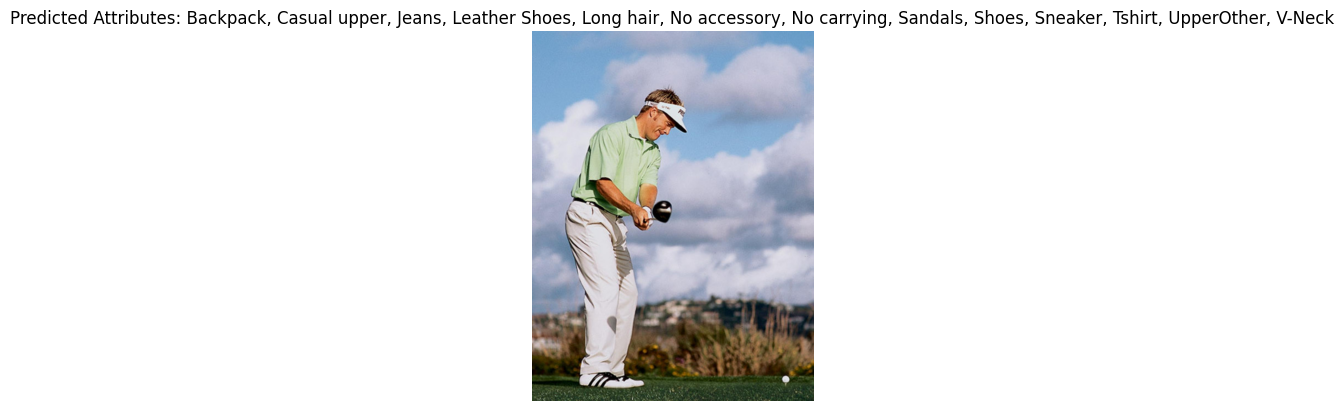

In [25]:
description = ['Age16-30',
                        'Age31-45',
                        'Age46-60',
                        'AgeAbove61',
                        'Backpack',
                        'CarryingOther',
                        'Casual lower',
                        'Casual upper',
                        'Formal lower',
                        'Formal upper',
                        'Hat',
                        'Jacket',
                        'Jeans',
                        'Leather Shoes',
                        'Logo',
                        'Long hair',
                        'Male',
                        'Messenger Bag',
                        'Muffler',
                        'No accessory',
                        'No carrying',
                        'Plaid',
                        'PlasticBags',
                        'Sandals',
                        'Shoes',
                        'Shorts',
                        'Short Sleeve',
                        'Skirt',
                        'Sneaker',
                        'Stripes',
                        'Sunglasses',
                        'Trousers',
                        'Tshirt',
                        'UpperOther',
                        'V-Neck']

test_single_image('/content/drive/My Drive/hacktech/test/Person Attibute detection Evaluation datasets/Evaluationdata (3).jpg',model,description)

In [ ]:
torch.cuda.empty_cache()